# Yale Hackathon

## 1b

Read pickle file and output array

In [2]:
from functions_library import *
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import dynamiqs as dq
import jax.numpy as jnp
from scipy.ndimage import zoom, gaussian_filter, sobel, maximum_filter,label, find_objects, shift

Code is called from a functions library. We want to adjust the values so that the Wigner function can take on both positive and negative values. The data is thus shifted so the W=0 values bisect the average of the max and min values in the array.

Data was centered around midpoint value: 0.3124


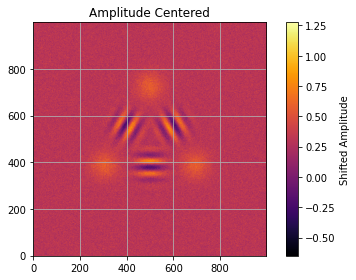

In [ ]:
# Load the pickle file and extract the third element
x, y, data = read_pickle("data\\synthetic\\noisy_wigner_8.pickle")

# Target shape: 75 x 75
scale = 1
zoom_factors = (scale, scale)
data_rescaled = zoom(data, zoom_factors)

def center_values_to_midpoint(array):
    """
    Translates the values in the input 2D array so that the new zero level 
    is the midpoint between the global max and min values.

    Parameters:
        array (np.ndarray): 2D input array (e.g., Wigner function or amplitude map)

    Returns:
        shifted_array (np.ndarray): Value-shifted array (centered at 0)
        midpoint (float): The value subtracted (mean of global max and min)
    """
    max_val = np.max(array)
    min_val = np.min(array)
    midpoint = (max_val + min_val) / 2

    shifted_array = array - midpoint
    return shifted_array, midpoint

# Assuming your data is in a variable `A`
A_rescaled, midpoint = center_values_to_midpoint(data_rescaled)

print(f"Data was centered around midpoint value: {midpoint:.4f}")

plt.imshow(data_rescaled, cmap="inferno", origin="lower")
plt.colorbar(label="Shifted Amplitude")
plt.title("Amplitude Centered")
plt.grid(True)
plt.tight_layout()
plt.show()

We want to use an importance sampling algorithm to choose points of interest to sample. Such algorithms include metropolis-hastings, importance sampling, rejection sampling etc. We employ such a scheme here using peak detection and probabilistic sampling from the Wigner function

Detected 46 points of interest.


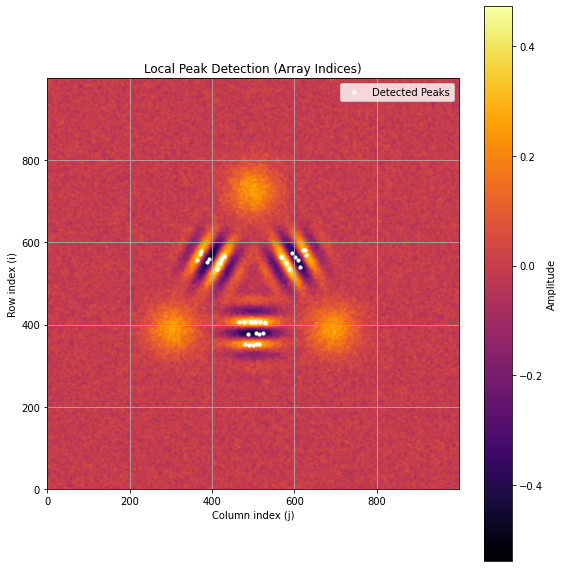

In [4]:
# === STEP 1: Smooth the data to reduce noise (optional) ===
A_rescaled = gaussian_filter(A_rescaled, sigma=2)
A_non_rescaled = gaussian_filter(data_rescaled, sigma=2)

# === STEP 2: Detect local peaks as array indices ===
def find_local_peak_indices(amplitude_map, rel_threshold=0.8, neighborhood_size=5):
    """
    Returns array indices (i, j) where local maxima occur in the 2D amplitude_map.
    Only keeps peaks above rel_threshold * max(amplitude_map).
    """
    local_max = maximum_filter(amplitude_map, size=neighborhood_size)
    peak_mask = (amplitude_map == local_max) & (amplitude_map > rel_threshold * amplitude_map.max())

    labeled, _ = label(peak_mask)
    slices = find_objects(labeled)

    peak_indices = []
    for slc in slices:
        if slc is None:
            continue
        i_slice, j_slice = slc
        i = (i_slice.start + i_slice.stop - 1) // 2
        j = (j_slice.start + j_slice.stop - 1) // 2
        peak_indices.append((i, j))  # array indices

    return np.array(peak_indices, dtype=int)

# === STEP 3: Detect peaks ===
peaks = find_local_peak_indices(A_rescaled, rel_threshold=0.8, neighborhood_size=8)
alphas = find_local_peak_indices(A_non_rescaled, rel_threshold=0.8, neighborhood_size=8)
troughs = find_local_peak_indices(-A_rescaled, rel_threshold=0.8, neighborhood_size=8)

# Combine them into one array
combined_coords = np.vstack((peaks, troughs,alphas))  # shape: (N_total, 2)

print(f"Detected {len(combined_coords)} points of interest.")
# combined_coords is now an (N_peaks, 2) array of (i, j) array indices

# === STEP 4: Plot the result using array index space ===
##############################################################################
plt.figure(figsize=(8, 8))
plt.imshow(A_rescaled, cmap='inferno', origin='lower')
plt.colorbar(label="Amplitude")

if len(combined_coords) > 0:
    i_vals, j_vals = combined_coords[:, 0], combined_coords[:, 1]
    plt.scatter(j_vals, i_vals, s=10, color='white', label='Detected Peaks')  # smaller dots (s=10)

plt.title("Local Peak Detection (Array Indices)")
plt.xlabel("Column index (j)")
plt.ylabel("Row index (i)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Compute probabilities wk

In [5]:
def compute_wk_from_peaks(data_rescaled, peak_coords):
    W_vals = np.array([
        data_rescaled[i, j] for i, j in peak_coords
    ])
    w_ks = 0.5 * (1 + (np.pi / 2) * W_vals)
    return w_ks

wk_list = compute_wk_from_peaks(data_rescaled, combined_coords)

Compute the $E$ matrix for different $\alpha$

In [6]:
def generate_E_alpha_list(wk_list, dim):
    """
    Generate a list of E_alpha_k measurement operators.

    Parameters:
    - wk_list: list of complex displacements (alpha_k)
    - dim: Hilbert space dimension (e.g., 10 or 20)

    Returns:
    - E_wk_list: list of QArrays representing each E_{alpha_k}
    """
    E_wk_list = []
    I = dq.eye(dim)
    P = dq.parity(dim)

    for n in range(len(wk_list)):
        real_part = x[combined_coords[n, 0]].item()
        imag_part = y[combined_coords[n, 1]].item()
        alpha = real_part + 1j * imag_part
        Disp = dq.displace(dim, alpha)
        E_alpha = 0.5 * (I + Disp @ P @ dq.dag(Disp))
        E_wk_list.append(E_alpha)

    return E_wk_list

Use a Hilbert space of $n=150$ then chop it to the size of the wk list 

In [7]:
E_list = generate_E_alpha_list(wk_list, 150)
E_list_chopped = [i[:wk_list.shape[0], :wk_list.shape[0]] for i in E_list]

In [ ]:
def reconstruct_density_matrix_cvxpy(E_list, w_list):
    """
    Reconstruct a physical density matrix rho that minimizes
    sum_k |Tr(E_k @ rho) - w_k|^2 using CVXPY.

    Parameters:
    - E_list: list of (dim x dim) Hermitian measurement operators (NumPy or QArrays)
    - w_list: list/array of observed values w_k (real)

    Returns:
    - rho_opt: optimized (dim x dim) density matrix as a NumPy array
    """
    dim = E_list[0].shape[0]
    rho = cp.Variable((dim, dim), complex=True)

    # Physical constraints
    constraints = [
        rho >> 0,                # PSD
        cp.trace(rho) == 1,      # Normalized
        rho == rho.H             # Hermitian
    ]

    # Least squares objective: minimize sum_k |Tr(E_k @ rho) - w_k|^2
    residuals = [cp.trace(E @ rho) - wk for E, wk in zip(E_list, w_list)]
    objective = cp.Minimize(cp.sum_squares(cp.hstack(residuals)))

    # Solve
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=True) #MY RESULTS MAY BE DIFFERENT FROM YOURS BECAUSE I USED cp.MOSEK HERE. IF YOU RUN AND SEE THE RESULT IS DIFFERENT THIS IS WHY

    return rho.value

In [ ]:
rho_est = reconstruct_density_matrix_cvxpy(E_list_chopped, wk_list);

Choose an $n$ to truncate the Hilbert space further.

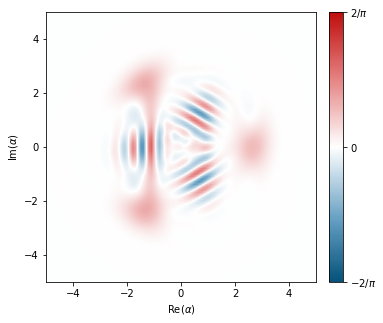

In [41]:
n_truncate = 17
chopped_rho = rho_est[:n_truncate, :n_truncate]/np.trace(rho_est[:n_truncate, :n_truncate])
dq.plot.wigner(dq.todm(chopped_rho))

To be done: Fidelity defined up to a phase and $\alpha$ are still not fitted/unknown from the original file.

Final output is density matrix

In [19]:
print(chopped_rho)

[[ 2.56950867e-03-4.94744040e-19j -4.71614421e-03-1.13358789e-03j
   1.45950682e-02+3.03379287e-03j ...  6.39651378e-05-1.41222260e-04j
  -1.23011888e-03-3.88320022e-04j  1.34020386e-03+9.84361132e-05j]
 [-4.71614421e-03+1.13358789e-03j  9.15809069e-03-1.17469884e-18j
  -2.81294826e-02+8.66967388e-04j ... -5.51040172e-05+2.87441319e-04j
   2.42925863e-03+1.70050021e-04j -2.50342737e-03+4.10612211e-04j]
 [ 1.45950682e-02-3.03379287e-03j -2.81294826e-02-8.66967388e-04j
   8.64996749e-02+2.42809828e-19j ...  1.96514949e-04-8.77829828e-04j
  -7.44689884e-03-7.52637892e-04j  7.72978505e-03-1.02420980e-03j]
 ...
 [ 6.39651378e-05+1.41222260e-04j -5.51040172e-05-2.87441319e-04j
   1.96514949e-04+8.77829828e-04j ...  8.87061515e-06+4.03607364e-19j
  -8.21215687e-06-7.76434536e-05j  2.74315133e-05+7.74690434e-05j]
 [-1.23011888e-03+3.88320022e-04j  2.42925863e-03-1.70050021e-04j
  -7.44689884e-03+7.52637892e-04j ... -8.21215687e-06+7.76434536e-05j
   6.46822027e-04-4.28159872e-19j -6.57314810e-

## Repeat Procedure for other Wigner functions

### Fock State 1

Detected 27 points of interest.


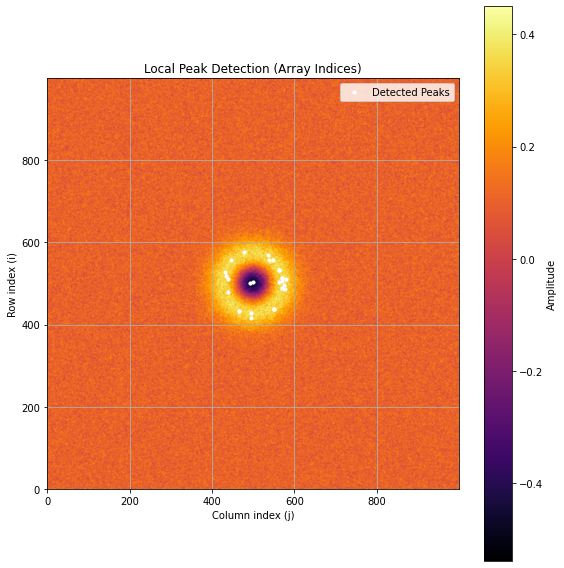

In [47]:
# Load the pickle file and extract the third element
x, y, data = read_pickle("data\\synthetic\\noisy_wigner_1.pickle")

# Target shape: 75 x 75
scale = 1
zoom_factors = (scale, scale)
data_rescaled = zoom(data, zoom_factors)

# Assuming your data is in a variable `A`
A_rescaled, midpoint = center_values_to_midpoint(data_rescaled)
A_rescaled = gaussian_filter(A_rescaled, sigma=1)
A_non_rescaled = gaussian_filter(data_rescaled, sigma=1)

#Run metropolis hastings (there are meta parameters you will need to change)
peaks = find_local_peak_indices(A_rescaled, rel_threshold=0.93, neighborhood_size=12)
alphas = find_local_peak_indices(A_non_rescaled, rel_threshold=0.93, neighborhood_size=12)
troughs = find_local_peak_indices(-A_rescaled, rel_threshold=0.93, neighborhood_size=12)

# Combine them into one array
combined_coords = np.vstack((peaks, troughs,alphas))  # shape: (N_total, 2)

print(f"Detected {len(combined_coords)} points of interest.")
# combined_coords is now an (N_peaks, 2) array of (i, j) array indices

# === STEP 4: Plot the result using array index space ===
##############################################################################
plt.figure(figsize=(8, 8))
plt.imshow(A_rescaled, cmap='inferno', origin='lower')
plt.colorbar(label="Amplitude")

if len(combined_coords) > 0:
    i_vals, j_vals = combined_coords[:, 0], combined_coords[:, 1]
    plt.scatter(j_vals, i_vals, s=10, color='white', label='Detected Peaks')  # smaller dots (s=10)

plt.title("Local Peak Detection (Array Indices)")
plt.xlabel("Column index (j)")
plt.ylabel("Row index (i)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
wk_list = compute_wk_from_peaks(data_rescaled, combined_coords)
E_list = generate_E_alpha_list(wk_list, 150)
E_list_chopped = [i[:wk_list.shape[0], :wk_list.shape[0]] for i in E_list]
rho_est = reconstruct_density_matrix_cvxpy(E_list_chopped, wk_list);

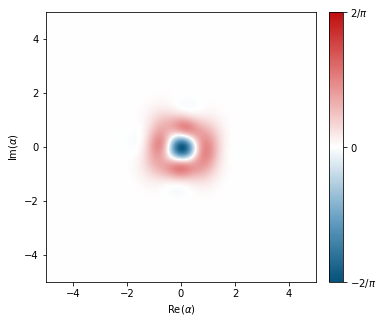

In [ ]:
n_truncate = 7
chopped_rho = rho_est[:n_truncate, :n_truncate]/np.trace(rho_est[:n_truncate, :n_truncate])
dq.plot.wigner(dq.todm(chopped_rho))

**Fock state-1 with $96\%$ fidelity**

In [ ]:
dq.fidelity(chopped_rho,dq.fock(n_truncate, 1))

Array(0.96336967, dtype=float32)

## Cat State

Detected 11 points of interest.


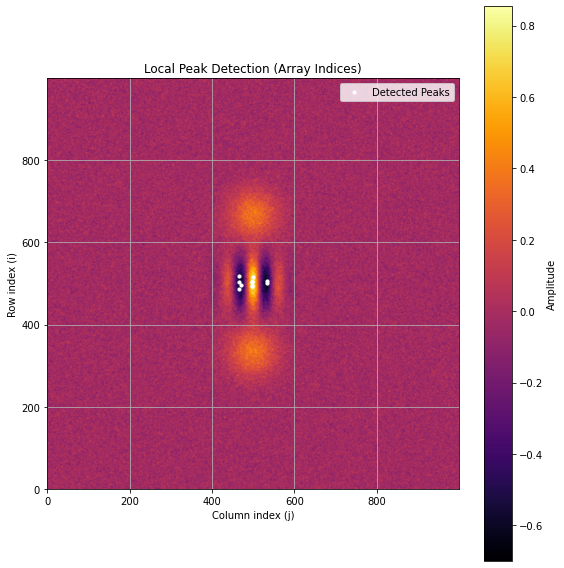

In [60]:
# Load the pickle file and extract the third element
x, y, data = read_pickle("data\\synthetic\\noisy_wigner_6.pickle")

# Target shape: 75 x 75
scale = 1
zoom_factors = (scale, scale)
data_rescaled = zoom(data, zoom_factors)

# Assuming your data is in a variable `A`
A_rescaled, midpoint = center_values_to_midpoint(data_rescaled)
A_rescaled = gaussian_filter(A_rescaled, sigma=1)
A_non_rescaled = gaussian_filter(data_rescaled, sigma=1)

#Run metropolis hastings (there are meta parameters you will need to change)
peaks = find_local_peak_indices(A_rescaled, rel_threshold=0.93, neighborhood_size=12)
alphas = find_local_peak_indices(A_non_rescaled, rel_threshold=0.93, neighborhood_size=12)
troughs = find_local_peak_indices(-A_rescaled, rel_threshold=0.93, neighborhood_size=12)

# Combine them into one array
combined_coords = np.vstack((peaks, troughs,alphas))  # shape: (N_total, 2)

print(f"Detected {len(combined_coords)} points of interest.")
# combined_coords is now an (N_peaks, 2) array of (i, j) array indices

# === STEP 4: Plot the result using array index space ===
##############################################################################
plt.figure(figsize=(8, 8))
plt.imshow(A_rescaled, cmap='inferno', origin='lower')
plt.colorbar(label="Amplitude")

if len(combined_coords) > 0:
    i_vals, j_vals = combined_coords[:, 0], combined_coords[:, 1]
    plt.scatter(j_vals, i_vals, s=10, color='white', label='Detected Peaks')  # smaller dots (s=10)

plt.title("Local Peak Detection (Array Indices)")
plt.xlabel("Column index (j)")
plt.ylabel("Row index (i)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [61]:
wk_list = compute_wk_from_peaks(data_rescaled, combined_coords)
E_list = generate_E_alpha_list(wk_list, 150)
E_list_chopped = [i[:wk_list.shape[0], :wk_list.shape[0]] for i in E_list]
rho_est = reconstruct_density_matrix_cvxpy(E_list_chopped, wk_list);

                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 13 09:41:12 AM: Your problem has 121 variables, 243 constraints, and 0 parameters.
(CVXPY) Apr 13 09:41:12 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 13 09:41:12 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 13 09:41:12 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 13 09:41:12 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 13 09:41:12 AM: Compiling problem (target solver=MOSEK).


Final cat state looks great!

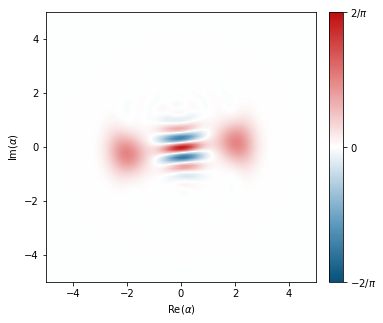

In [78]:
n_truncate = 11
chopped_rho = rho_est[:n_truncate, :n_truncate]/np.trace(rho_est[:n_truncate, :n_truncate])
dq.plot.wigner(dq.todm(chopped_rho))

Turns out the fidelity does not depend on the phase since they cancel out and we have a $94\%$ fidelity

In [87]:
alpha = 2.05
psi = dq.unit(dq.coherent(n_truncate, alpha) + dq.coherent(n_truncate, - alpha) )
dq.fidelity(chopped_rho,psi)

Array(0.94435847, dtype=float32)